In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


The BIWI dataset has several things, one of which is a dot at the center of each face. We want to predict this. The dataset with images converted to JPEG are downloadable from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
from fastai import *
from fastai.vision import *

In [2]:
!wget https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz

--2019-02-09 05:42:17--  https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.213
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452316199 (431M) [application/x-tar]
Saving to: ‘biwi_head_pose.tgz’

biwi_head_pose.tgz  100%[===================>] 431.36M  36.7MB/s    in 12s     

2019-02-09 05:42:30 (35.0 MB/s) - ‘biwi_head_pose.tgz’ saved [452316199/452316199]



In [3]:
!tar xvzf biwi_head_pose.tgz

biwi_head_pose/
biwi_head_pose/io_sample.cpp
biwi_head_pose/06/
biwi_head_pose/06/frame_00561_pose.txt
biwi_head_pose/06/frame_00145_pose.txt
biwi_head_pose/06/frame_00491_pose.txt
biwi_head_pose/06/frame_00030_pose.txt
biwi_head_pose/06/frame_00113_rgb.jpg
biwi_head_pose/06/frame_00227_rgb.jpg
biwi_head_pose/06/frame_00054_rgb.jpg
biwi_head_pose/06/frame_00443_pose.txt
biwi_head_pose/06/frame_00031_pose.txt
biwi_head_pose/06/frame_00069_pose.txt
biwi_head_pose/06/frame_00225_rgb.jpg
biwi_head_pose/06/frame_00215_pose.txt
biwi_head_pose/06/frame_00142_rgb.jpg
biwi_head_pose/06/frame_00504_rgb.jpg
biwi_head_pose/06/frame_00116_pose.txt
biwi_head_pose/06/frame_00139_pose.txt
biwi_head_pose/06/frame_00291_rgb.jpg
biwi_head_pose/06/frame_00339_pose.txt
biwi_head_pose/06/frame_00397_rgb.jpg
biwi_head_pose/06/frame_00178_pose.txt
biwi_head_pose/06/frame_00087_pose.txt
biwi_head_pose/06/frame_00031_rgb.jpg
biwi_head_pose/06/frame_00112_rgb.jpg
biwi_head_pose/06/frame_00588_pose.txt
biwi_head_

In [5]:
!pwd

/content


In [10]:
path = Path('/content')
(path/'biwi_head_pose').ls()

[PosixPath('/content/biwi_head_pose/03'),
 PosixPath('/content/biwi_head_pose/24.obj'),
 PosixPath('/content/biwi_head_pose/06.obj'),
 PosixPath('/content/biwi_head_pose/21.obj'),
 PosixPath('/content/biwi_head_pose/21'),
 PosixPath('/content/biwi_head_pose/08.obj'),
 PosixPath('/content/biwi_head_pose/18'),
 PosixPath('/content/biwi_head_pose/24'),
 PosixPath('/content/biwi_head_pose/16.obj'),
 PosixPath('/content/biwi_head_pose/15'),
 PosixPath('/content/biwi_head_pose/05'),
 PosixPath('/content/biwi_head_pose/17.obj'),
 PosixPath('/content/biwi_head_pose/11.obj'),
 PosixPath('/content/biwi_head_pose/04'),
 PosixPath('/content/biwi_head_pose/14'),
 PosixPath('/content/biwi_head_pose/18.obj'),
 PosixPath('/content/biwi_head_pose/08'),
 PosixPath('/content/biwi_head_pose/02.obj'),
 PosixPath('/content/biwi_head_pose/07'),
 PosixPath('/content/biwi_head_pose/22'),
 PosixPath('/content/biwi_head_pose/19'),
 PosixPath('/content/biwi_head_pose/12.obj'),
 PosixPath('/content/biwi_head_pose/

In [12]:
!cat {path}/'biwi_head_pose/07/frame_00129_pose.txt'

0.996774 0.0686497 -0.0415689 
-0.0304361 0.802631 0.595698 
0.0742591 -0.592512 0.802132 

3.88372 -62.1133 879.125 



## Data Preprocessing/Handling

In [14]:
path = path/'biwi_head_pose'
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

In [0]:
def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

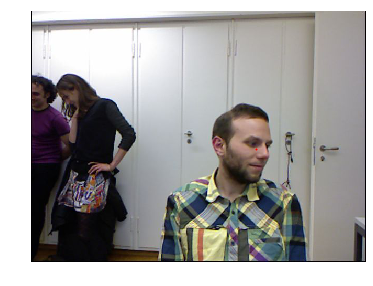

In [18]:
fname = '09/frame_00667_rgb.jpg'

img = open_image(path/fname)
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

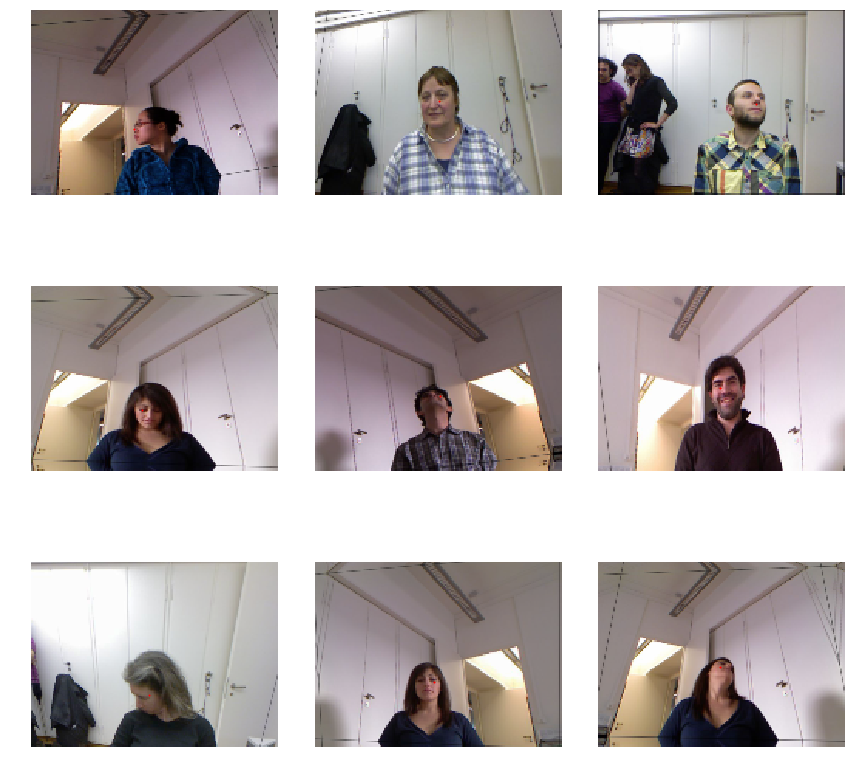

In [20]:
data.show_batch(rows=3)

## Create model

In [0]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

epoch,train_loss,valid_loss


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


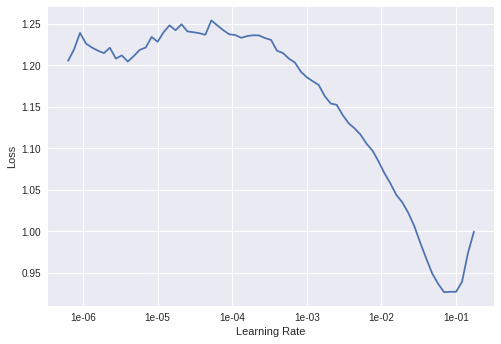

In [22]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss
1,0.063573,0.007480
2,0.023434,0.003376
3,0.011915,0.001342
4,0.007103,0.000870
5,0.005582,0.001102


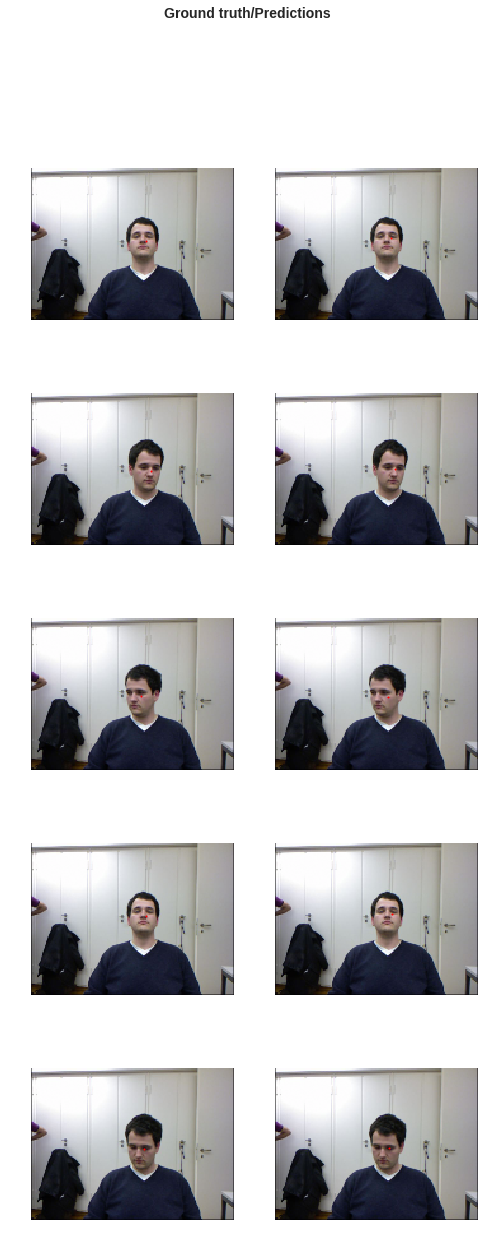

In [25]:
learn.show_results()